<a href="https://colab.research.google.com/github/AdamW1002/CodeCloneDetectionCOMP599/blob/main/codebertsimilar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load required things and setup environment

In [1]:
!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl (152.9 MB)


In [2]:
!pip install transformers

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import psutil 
import matplotlib.pyplot as plt
import pdb

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met

In [4]:


MAX_TOKEN_DIM = 512 #controls padding and input to classifier
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')
  torch.cuda.device(device)
try:
  print(xm.xla_device())
  device = xm.xla_device()
  print("USING TPU")
except:
  print("NOT USING TPU")
  pass
print(torch.cuda.is_available())
print(device)
if torch.cuda.is_available():
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
  print("using cuda")
  

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
codebert = AutoModel.from_pretrained("microsoft/codebert-base")
torch.set_printoptions(precision=7)

xla:1
USING TPU
False
xla:1


In [5]:
def load_data():
  f = open("/content/drive/MyDrive/CloneData/data.jsonl") #read sniipets and indices
  entries = f.readlines()
  objects = [json.loads(x) for x in entries] #load all functions
  idx_to_function = dict()
 
  for snippet in objects:#map to associate index to func
    
    idx_to_function[snippet["idx"]] = snippet["func"]

  return idx_to_function

In [6]:
def pairify_file(lines : list, idx_to_function : dict) -> tuple:
  examples = []
  
  for line in lines:
    line_entries = line.replace("\t", " ").split(" ") #given line x y label, divide to find if x is y according to label
    #print(line)
    x = line_entries[0]
    y = line_entries[1]
    label = line_entries[2]
    
    examples.append((idx_to_function[x], idx_to_function[y], float(label))) #convert label to float for pytorch
  return examples


In [7]:
def split_and_label_data(idx_to_function : dict): #convert pairs to useful training examples
  return tuple(map(  lambda x : pairify_file(open(x).readlines(), idx_to_function)  , ["/content/drive/MyDrive/CloneData/train.txt","/content/drive/MyDrive/CloneData/test.txt", "/content/drive/MyDrive/CloneData/valid.txt"]))


# Pre-calculate embeddings

In [8]:
def embed(x : str) -> torch.TensorType:
  with torch.no_grad():
    code_tokens=tokenizer.tokenize(x)

    if len(code_tokens) >= 510: #confirm tokes arent too big for model
      return None
    tokens=[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]

    tokens_ids=tokenizer.convert_tokens_to_ids(tokens)
    context_embeddings=codebert(torch.tensor(tokens_ids, device = device)[None,:])[0]
    
    flattened = torch.flatten(context_embeddings)
    
    
    
    return flattened #torch.clamp(flattened, min = -2, max = 2) #return flattened embedding vector

In [9]:
def embed_data(data : list) -> list: #takes prog1, prog2, label and replaces prog with their embedding for every item in the list and filters out too long items
  embedded_data = []
  i = 0
  
  for x,y, label in data:

    if i % 10 == 0:  
      #print("using {} MB for {} of {}, embedded {}".format(psutil.Process().memory_info().rss / (1024 * 1024),i, len(data), len(embedded_data)))
      pass
    emb_x = embed(x[0])
    emb_y = embed(y[0])
    #pdb.set_trace()
    if emb_x != None and emb_y != None: #check code isnt too long
      x_embed = emb_x #Standardize embeddings lengths since they depend on #of tokens
      y_embed = emb_y
     
      padding_length_x  = (MAX_TOKEN_DIM * 768 - x_embed.size()[0])
      padding_length_y  = (MAX_TOKEN_DIM * 768 - y_embed.size()[0])
      
      x_padded = torch.nn.functional.pad(x_embed, (int(padding_length_x/2), int(padding_length_x/2)))
      y_padded = torch.nn.functional.pad(y_embed, (int(padding_length_y/2), int(padding_length_y/2)))
      embedded_data.append((x_padded,y_padded, label))
    i += 1
  #print(f"unique entries {len(set([embedded_data[0][0],  embedded_data[1][0]]  ))}")
  return embedded_data 

In [10]:
class CloneDataset(Dataset): #dataset 

  def __init__(self,x : list ,y : list,labels : list):
    assert len(x) == len(y) and len(y) == len(labels) #make sure all the same size
    #standard boilerplate
    self.x = (x)
    self.y = (y)
    self.labels = labels
    self.length = len(x)
    
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx], self.labels[idx]
  
  def __len__(self):
    return self.length

In [11]:

#test_data = embed_data(test_data)
#validation_data = embed_data(validation_data)

In [12]:
def tokenize(code : str) -> list:
  with torch.no_grad():
    code_tokens=tokenizer.tokenize(code)
    

    if len(code_tokens) >= 510: #confirm tokes arent too big for model
      return None
    code_tokens += [tokenizer.pad_token] *  (510 - len(code_tokens)) #pad out to 510 which becomes 512
    tokens=[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]

    tokens_ids=tokenizer.convert_tokens_to_ids(tokens)
    return torch.tensor(tokens_ids, device = device)[None,:]

In [13]:
def build_dataset(data : list):
  x_list = []
  y_list = []
  label_list = []
  i = 0
  for x,y,l in data:#convert list of tuples to 3 separate lists
    #x.to(device)
    #y.to(device)
    if i % 250 == 0:
        print(f"on data point {i}")
    x_tokens = tokenize(x)
    y_tokens = tokenize(y)
    if  not x_tokens is None and not y_tokens is None: #confirmm both seqs work
      x_list.append(x_tokens)
      y_list.append(y_tokens)
      label_list.append(l)
    i+=1

  return CloneDataset(x_list, y_list, label_list)

In [30]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
       
        
        #A note on architecture for those interested, we eat CodeBERT embeddings of size X  * 768 which have been flattened
        # Now those vectors are each fed into FF layer(s)
        #Then they're concatnated and fed thru more FF layer(s)
        # Then their dimensionality is shrunk down to 1, which is sigmoided
        layer2_size = 512
        layer3_size = 256
        layer4_size = 32
        #self.xlayer_1 = nn.Linear(MAX_TOKEN_DIM * 768, layer2_size)
        #self.ylayer_1 = nn.Linear(MAX_TOKEN_DIM * 768, layer2_size)

        self.ff1 = nn.Linear( 2 * MAX_TOKEN_DIM * 768, layer2_size )
        self.ff2 = nn.Linear(layer2_size, 1)
        #self.ff3 = nn.Linear(layer4_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.batchNorm1 = nn.BatchNorm1d(layer2_size, affine = False)

        #nn.init.xavier_normal_(self.xlayer_1.weight)
        #nn.init.xavier_normal_(self.ylayer_1.weight)
        nn.init.xavier_normal_(self.ff1.weight)
        nn.init.xavier_normal_(self.ff2.weight)
        #nn.init.xavier_normal_(self.ff3.weight)

        #self.to(device)


    def forward(self, x,y):
      
       combined = torch.cat((x, y),1)
      
       out = self.ff1(combined)
       #print(f"out is {out}")
       
       out = self.sigmoid(out)
       #xm.mark_step()
       out = self.batchNorm1(out)
       #xm.mark_step()
       out = self.ff2(out)
       #xm.mark_step()
       #out = self.relu(out)
       #out = self.ff3(out)
       
       #out = self.sigmoid(out)
       return out


In [15]:
idx_to_function = load_data()
train_data, test_data,validation_data = split_and_label_data(idx_to_function)
print(len(train_data))
train_data = build_dataset(train_data[:3000])



Token indices sequence length is longer than the specified maximum sequence length for this model (1023 > 512). Running this sequence through the model will result in indexing errors


901028
on data point 0
on data point 250
on data point 500
on data point 750
on data point 1000
on data point 1250
on data point 1500
on data point 1750
on data point 2000
on data point 2250
on data point 2500
on data point 2750


In [16]:
trainLoader = DataLoader(train_data, batch_size= 128, shuffle = False, drop_last = True)# BATCH SIZES MUST BE MULTIPLES OF 128

In [17]:
class F1(nn.Module):
    def __init__(self):
        super(F1, self).__init__()
       


    def forward(self, label,pred):
      with torch.no_grad():
        x = torch.round(pred) - label
        x  = torch.flatten(x)
        tp = torch.where(x == 0, 1, 0)
        tp_count = float(torch.numel(torch.nonzero(tp)))

        fp = torch.where(x == 1, 1, 0)
        fp_count = float(torch.numel(torch.nonzero(fp)))

        fn = torch.where(x == -1, 1, 0)
        fn_count = float(torch.numel(torch.nonzero(fn)))
        denom = (tp_count + .5 * (fp_count + fn_count))
        #print(tp_count, fp_count, fn_count)
        #print(denom)
        if denom == 0:
          return 0
        return float(tp_count) / float(denom)

# Train model

In [31]:
def train():
  torch.cuda.empty_cache() 
  epochs  = 2 #standard boilerplate
  model = Classifier()
  print(model.ff1.weight.device)
  #criterion = nn.BCELoss()
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters())
  scorer = F1()
  scorer.to(device)

  loss_history = []
  f1_history = []
  model.to(device)
  codebert.to(device)
  for epoch in range(epochs): #standard training procedure
    torch.cuda.empty_cache() 
    epoch_loss = 0
    
    tp_count = 0 #setup for f1 score
    fp_count = 0
    fn_count = 0
    f1 = 0
    
    j = 0
    for x,y,label in trainLoader:
      torch.cuda.empty_cache() 
     
      #print(f"b0 {batch[0]}")
      #print(f"b1 {batch[1]}")
      #print(f"b2 {batch[2]}")

      with torch.no_grad():
        x = torch.reshape(x, (x.shape[0], x.shape[2])) # make Batch size X 1 X 512 into Batch size X 512
        y = torch.reshape(y, (y.shape[0], y.shape[2]))



        
       
        #model.to("cpu")
        #codebert.to(device)
        #print(f"before embedding codebert is on {codebert.device}")
        embed_start = datetime.now()
        embedded_x=codebert(x)[0]
       
        embedded_y=codebert(y)[0]
       
        embed_end = datetime.now()
        #codebert.to("cpu")
        #model.to(device)
        #print(embedded_x.shape)
        #print(embedded_y.shape)
        embedded_x.to('cpu')
        embedded_y.to('cpu')
        embedded_x = torch.flatten(embedded_x, start_dim = 1)
        embedded_y = torch.flatten(embedded_y, start_dim = 1)
        embedded_x.to(device)
        embedded_y.to(device)
        #print(embedded_x.shape)
        #print(embedded_y.shape)
       
      
      model_start = datetime.now()
      optimizer.zero_grad()
      #print(embedded_x.dtype)
      #print("max x {}".format(torch.max(embedded_x)))
      #print(f"before prediction model is on device {model.ff1.weight.device}")
      pred = model(embedded_x,embedded_y)
      
     
      #print(f"pred is {pred.shape} {pred}")
     


      #print(label.shape)
      #print(pred.view(10).shape)
      loss_start = datetime.now()
      loss = criterion(torch.flatten(pred.unsqueeze(1)),torch.flatten(label.unsqueeze(1)))
      #loss = torch.nn.functional.binary_cross_entropy_with_logits(torch.flatten(pred.unsqueeze(1)),torch.flatten(label.unsqueeze(1)))
      loss.backward()
      #nn.utils.clip_grad_norm_(model.parameters(), max_norm = 2.0, norm_type = 2.0)
      optimizer.step()
      xm.mark_step()
      
      loss_end = datetime.now()
      #print("pred is {}".format(pred))
      epoch_loss += loss.item()
      end = datetime.now()
      model_delta_t = end-model_start 
      embed_delta_t = embed_end-embed_start
      loss_delta_t = loss_start-loss_end
     
     
      with torch.no_grad():
        f1_score = scorer(label,pred)
        xm.mark_step()
        score_start = datetime.now()
        loss_history.append(loss.item())
        f1_history.append(f1_score)
        if j % 1 == 0:
          print(torch.min(pred), torch.max(pred))
          print("time per model iteration {} s".format(model_delta_t.microseconds / 10**6))
          print("time per embed iteration {} s".format(embed_delta_t.microseconds / 10**6))
          print("time per loss iteration {} s".format(loss_delta_t.microseconds / 10**6))
          
          print("at iteration{} of epoch {} total loss is {} , f1 is {}, tp is {}, current loss is {}".format(j,epoch,epoch_loss, f1_history[-1], tp_count, loss.item()))
      j+=1
      #print(met.metrics_report())
      
      
        #
        #calculate scores
        #pred_rounded = torch.round(pred)
        ##pred._rounded.to('cpu')
        #print(label.shape)
        #label.to('cpu')
        #pred_rounded.to('cpu')
        #for i in range(label.shape[0]):
        #  #print(f"i is {i}")
        #  if pred_rounded[i] == 1 and label[i] == 1:
        #    tp_count += 1
        #  elif pred_rounded[i] == 1 and label[i] == 0:
        #    fp_count += 1
        #  elif pred_rounded[i] == 0 and label[i] == 1:
        #    fn_count += 1

        #
        #if (tp_count + .5 * (fp_count + fn_count)) != 0: #dont get 0 for denom of f1
        #  f1 = tp_count/(tp_count + .5 * (fp_count + fn_count))
        #
        ##loss = loss.item.to('cpu')
        #loss_history.append(loss.item())
        #f1_history.append(f1)
        #score_end = datetime.now()
        #print(f"{(score_end-score_start) / 10**6} s for scoring")
  return (loss_history,f1_history)

In [32]:
loss_history, f1_history = train()

cpu


RuntimeError: ignored

# Analzye results

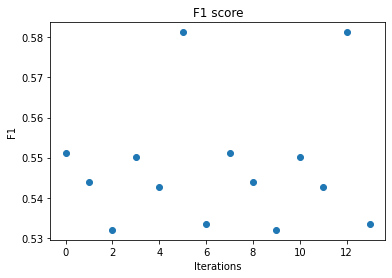

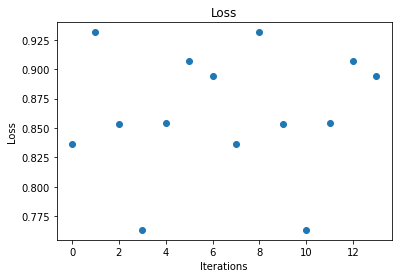

In [29]:
plt.scatter(list(range(len(f1_history))), f1_history)
plt.title("F1 score")
plt.xlabel("Iterations")
plt.ylabel("F1")
plt.show()
plt.scatter(list(range(len(loss_history))), loss_history)
plt.title("Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()